Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Self-Supervised Pre-training - step-by-step RandCoarseDropoutd transform debug

ℹ️ This notebook is based on [this MONAI tutorial](https://github.com/Project-MONAI/tutorials/tree/main/self_supervised_pretraining/vit_unetr_ssl) and provides step-by-step visualisation of data augmentation necessary for the Self-Supervised Pre-training.

First, it uses augmentation (top row) to mutate the data and second, it utilizes regularized contrastive loss [3] to learn feature representations of the unlabeled data. The multiple augmentations are applied on a randomly selected 3D foreground patch from a 3D volume (selected by on the spinal cord mask). Two augmented views of the same 3D patch are generated for the contrastive loss as it functions by drawing the two augmented views closer to each other if the views are generated from the same patch, if not then it tries to maximize the disagreement.

The augmentations mutate the 3D patch in various ways, the primary task of the network is to reconstruct the original image. The different augmentations used are classical techniques such as in-painting [1], out-painting [1] and noise augmentation to the image by local pixel shuffling [2]. The secondary task of the network is to simultaneously reconstruct the two augmented views as similar to each other as possible via regularized contrastive loss [3] as its objective is to maximize the agreement.

For references, visit [this MONAI tutorial](https://github.com/Project-MONAI/tutorials/tree/main/self_supervised_pretraining/vit_unetr_ssl).

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
import os
import json
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.nn import L1Loss
from monai.utils import set_determinism, first
from monai.networks.nets import ViTAutoEnc
from monai.losses import ContrastiveLoss
from monai.data import (
    Dataset,
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
)
from monai.config import print_config

from monai.transforms import (
    LoadImaged,
    AsDiscreted,
    Compose,
    CropForegroundd,
    CopyItemsd,
    ResizeWithPadOrCropd,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    OneOf,
    NormalizeIntensityd,
    RandSpatialCropSamplesd,
    RandCropByPosNegLabeld,
    RandCoarseDropoutd,
    RandCoarseShuffled,
)

from load_data import load_data


##### Define file paths & output directory path

In [3]:
# Both images and labels (binary spinal cord masks) are loaded
json_path = os.path.normpath("/Users/valosek/data/experiments/vit_unetr_ssl/dataset_split_short_with_labels.json")
data_root = os.path.normpath("/Users/valosek/data/experiments/vit_unetr_ssl/spine-generic_with_labels")
logdir_path = os.path.normpath("/Users/valosek/data/experiments/vit_unetr_ssl/")

##### Create result logging directories, manage data paths & set determinism

In [4]:
train_list, val_list = load_data(data_root, json_path, logdir_path)
print("Total training data are {} and validation data are {}".format(len(train_list), len(val_list)))

Total training data are 3 and validation data are 1


### Define Transforms - reorient to RPI, resample to 1 mm iso

image shape: [51, 256, 256]


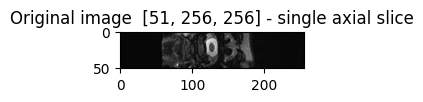

In [5]:
spatial_size=(64, 256, 256)
#roi_size=spatial_size
#roi_size=(64,128,128)
roi_size=(64,64,64)

keys=["image", "label"]

transforms = Compose(
    [
        # Load image data using the key "image"
        LoadImaged(keys=keys, image_only=True),
        # Ensure that the channel dimension is the first dimension of the image tensor.
        EnsureChannelFirstd(keys=keys),
        # Ensure that the image orientation is consistently RPI
        Orientationd(keys=keys, axcodes="RPI"),
        # Resample the images to a specified pixel spacing
        # NOTE: spine interpolation with order=2 is spline, order=1 is linear
        Spacingd(keys=keys, pixdim=(1.0, 1.0, 1.0), mode=(2,1)),
        # Normalize the intensity values of the image
        NormalizeIntensityd(keys=["image"], nonzero=False, channel_wise=False),
        # Remove background pixels to focus on regions of interest.
        #CropForegroundd(keys=["image"], source_key="image"),
    ]
)

# Sanity check -- plotting

check_ds = Dataset(data=train_list, transform=transforms)
check_loader = DataLoader(check_ds, batch_size=1)

slice=100
index=2
batch_to_plot = None
for i, batch in enumerate(check_loader):
    if i == index:  # indexing starts at 0
        batch_to_plot = batch
        break  # exit the loop as soon as the desired batch is found       

image_to_plot = batch_to_plot["image"][0][0]
ax1=plt.subplot(2,3,1)
ax1.set_title(f"Original image  {list(image_to_plot.shape)} - single axial slice")
ax1.imshow(image_to_plot[:,:,slice], cmap='gray')
plt.tight_layout()

print(f'image shape: {list(image_to_plot.shape)}')

### Define Transforms - reorient to RPI, resample to 1 mm iso, pad to `(64, 256, 256)`

image shape: [64, 256, 256]


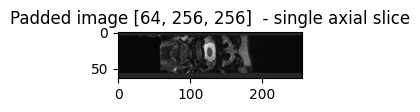

In [6]:
spatial_size=(64, 256, 256)
#roi_size=spatial_size
#roi_size=(64,128,128)
roi_size=(64,64,64)

keys=["image", "label"]

transforms = Compose(
    [
        # Load image data using the key "image"
        LoadImaged(keys=keys, image_only=True),
        # Ensure that the channel dimension is the first dimension of the image tensor.
        EnsureChannelFirstd(keys=keys),
        # Ensure that the image orientation is consistently RPI
        Orientationd(keys=keys, axcodes="RPI"),
        # Resample the images to a specified pixel spacing
        # NOTE: spine interpolation with order=2 is spline, order=1 is linear
        Spacingd(keys=keys, pixdim=(1.0, 1.0, 1.0), mode=(2,1)),
        # Normalize the intensity values of the image
        NormalizeIntensityd(keys=["image"], nonzero=False, channel_wise=False),
        # Remove background pixels to focus on regions of interest.
        #CropForegroundd(keys=["image"], source_key="image"),
        # Pad the image to a specified spatial size if its size is smaller than the specified dimensions
        ResizeWithPadOrCropd(keys=keys, spatial_size=spatial_size),
    ]
)

# Sanity check -- plotting

check_ds = Dataset(data=train_list, transform=transforms)
check_loader = DataLoader(check_ds, batch_size=1)

slice=100
index=2
batch_to_plot = None
for i, batch in enumerate(check_loader):
    if i == index:  # indexing starts at 0
        batch_to_plot = batch
        break  # exit the loop as soon as the desired batch is found       

image_to_plot = batch_to_plot["image"][0][0]
ax1=plt.subplot(2,3,1)
ax1.set_title(f"Padded image {list(image_to_plot.shape)}  - single axial slice")
ax1.imshow(image_to_plot[:,:,slice], cmap='gray')
plt.tight_layout()

print(f'image shape: {list(image_to_plot.shape)}')

### Define Transforms - reorient to RPI, resample to 1 mm iso, pad to `(64, 256, 256)`, crop two samples of `(64, 64 64)` around the label

patch shape: [64, 64, 64]
[0. 1.]
[0. 1.]


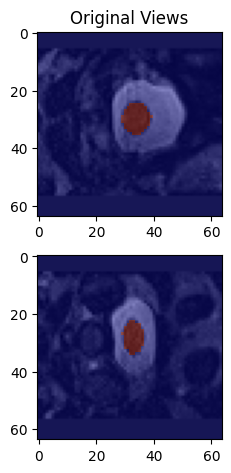

In [7]:
spatial_size=(64, 256, 256)
#roi_size=spatial_size
#roi_size=(64,128,128)
roi_size=(64,64,64)

keys=["image", "label"]

transforms = Compose(
    [
        # Load image data using the key "image"
        LoadImaged(keys=keys, image_only=True),
        # Ensure that the channel dimension is the first dimension of the image tensor.
        EnsureChannelFirstd(keys=keys),
        # Ensure that the image orientation is consistently RPI
        Orientationd(keys=keys, axcodes="RPI"),
        # Resample the images to a specified pixel spacing
        # NOTE: spine interpolation with order=2 is spline, order=1 is linear
        Spacingd(keys=keys, pixdim=(1.0, 1.0, 1.0), mode=(2,1)),
        # Normalize the intensity values of the image
        NormalizeIntensityd(keys=["image"], nonzero=False, channel_wise=False),
        # Remove background pixels to focus on regions of interest.
        #CropForegroundd(keys=["image"], source_key="image"),
        # Pad the image to a specified spatial size if its size is smaller than the specified dimensions
        ResizeWithPadOrCropd(keys=keys, spatial_size=spatial_size),
        AsDiscreted(keys='label', to_onehot=None, threshold=0.5),
        # Randomly crop samples of a specified size around the label (spinal cord)
        # Note that it seems that the transform randomly selects a foreground point from image, then use it as
        # center crop. This means that it can find the closest voxel that is just outside the SC and use it as the
        # center (hence it includes the SC)
        # https://github.com/Project-MONAI/MONAI/issues/452#issuecomment-636065502
        RandCropByPosNegLabeld(
            keys=keys,
            label_key="label",
            spatial_size=roi_size,
            pos=2,
            neg=1,
            num_samples=2,
            image_key="image",
            image_threshold=0,
        )
    ]
)

# Sanity check -- plotting

check_ds = Dataset(data=train_list, transform=transforms)
check_loader = DataLoader(check_ds, batch_size=1)

slice=roi_size[2]//3   # // int division
index=2
#batch_to_plot = first(check_loader)
for i, batch in enumerate(check_loader):
    if i == index:  # indexing starts at 0
        batch_to_plot = batch
        break  # exit the loop as soon as the desired batch is found       

print(f'patch shape: {list(batch_to_plot["image"][0][0].shape)}')

ax1=plt.subplot(2,3,1)
ax1.set_title('Original Views')
ax1.imshow(batch_to_plot["image"][0][0][:,:,slice], cmap='gray')
ax1.imshow(batch_to_plot["label"][0][0][:,:,slice], alpha=0.5, cmap='jet', interpolation='nearest')   # interpolation='nearest' has to be used to show binary mask
print(np.unique(batch_to_plot["label"][0][0][:,:,slice]))
# Note: the [1] dimension is added by 'RandSpatialCropSamplesd(num_samples=2)'
ax2=plt.subplot(2,3,4)
ax2.imshow(batch_to_plot["image"][1][0][:,:,slice], cmap='gray')
ax2.imshow(batch_to_plot["label"][1][0][:,:,slice], alpha=0.5,cmap='jet', interpolation='nearest')    # interpolation='nearest' has to be used to show binary mask
print(np.unique(batch_to_plot["label"][1][0][:,:,slice]))

plt.tight_layout()

### Define Transforms - reorient to RPI, resample to 1 mm iso, pad to `(64, 256, 256)`, crop two samples of `(64, 64, 64)` around the label, create copies for augmentation, debug RandCoarseDropoutd

patch shape: [64, 64, 64]


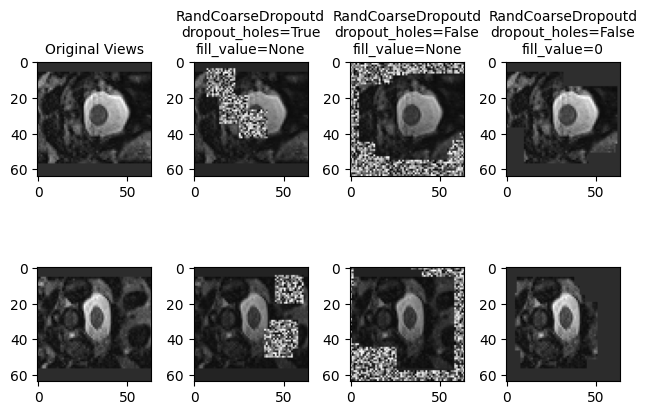

In [8]:
spatial_size=(64, 256, 256)
#roi_size=spatial_size
#roi_size=(64,128,128)
roi_size=(64,64,64)

keys=["image", "label"]

transforms = Compose(
    [
        # Load image data using the key "image"
        LoadImaged(keys=keys, image_only=True),
        # Ensure that the channel dimension is the first dimension of the image tensor.
        EnsureChannelFirstd(keys=keys),
        # Ensure that the image orientation is consistently RPI
        Orientationd(keys=keys, axcodes="RPI"),
        # Resample the images to a specified pixel spacing
        # NOTE: spine interpolation with order=2 is spline, order=1 is linear
        Spacingd(keys=keys, pixdim=(1.0, 1.0, 1.0), mode=(2,1)),
        # Normalize the intensity values of the image
        NormalizeIntensityd(keys=["image"], nonzero=False, channel_wise=False),
        # Remove background pixels to focus on regions of interest.
        #CropForegroundd(keys=["image"], source_key="image"),
        # Pad the image to a specified spatial size if its size is smaller than the specified dimensions
        ResizeWithPadOrCropd(keys=keys, spatial_size=spatial_size),
        AsDiscreted(keys='label', to_onehot=None, threshold=0.5),
        # Randomly crop samples of a specified size around the label (spinal cord)
        # Note that it seems that the transform randomly selects a foreground point from image, then use it as
        # center crop. This means that it can find the closest voxel that is just outside the SC and use it as the
        # center (hence it includes the SC)
        # https://github.com/Project-MONAI/MONAI/issues/452#issuecomment-636065502
        RandCropByPosNegLabeld(
            keys=keys,
            label_key="label",
            spatial_size=roi_size,
            pos=2,
            neg=1,
            num_samples=2,
            image_key="image",
            image_threshold=0,
        ),
        # Create copies of items in the dictionary under new keys, allowing for the same image to be manipulated
        # differently in subsequent transformations
        CopyItemsd(keys=["image"], times=3, names=["gt_image", "image_2", "image_3"], allow_missing_keys=False),
        
        # Randomly drop regions of the image
        RandCoarseDropoutd(
            keys=["image"], 
            prob=1.0, 
            holes=10, 
            spatial_size=roi_size[0]//4,
            dropout_holes=True,   # if True, dropout the regions of holes and fill value specified by 'fill_value'
            fill_value=None,      # if None, will compute the min and max value of input image then randomly select value to fill
        ),
        RandCoarseDropoutd(
            keys=["image_2"], 
            prob=1.0, 
            holes=10, 
            spatial_size=roi_size[0]//2,
            dropout_holes=False,   # if False, keep the holes and dropout the outside and fill value specified by 'fill_value'
            fill_value=None,       # if None, will compute the min and max value of input image then randomly select value to fill
        ),
        RandCoarseDropoutd(
            keys=["image_3"], 
            prob=1.0, 
            holes=10, 
            spatial_size=roi_size[0]//2,
            dropout_holes=False,   # if False, keep the holes and dropout the outside and fill value specified by 'fill_value'
            fill_value=0,          # if providing a number, will use it as constant value to fill all the regions
        )
    ]
)

# Sanity check -- plotting

check_ds = Dataset(data=train_list, transform=transforms)
check_loader = DataLoader(check_ds, batch_size=1)

slice=roi_size[2]//3   # // int division
index=2
batch_to_plot = None
for i, batch in enumerate(check_loader):
    if i == index:  # indexing starts at 0
        batch_to_plot = batch
        break  # exit the loop as soon as the desired batch is found       

print(f'patch shape: {list(batch_to_plot["image"][0][0].shape)}')

# Note: 'gt_image' is added by 'CopyItemsd'
ax1=plt.subplot(2,4,1)
ax1.set_title('Original Views', fontsize=10)
ax1.imshow(batch_to_plot["gt_image"][0][0][:,:,slice], cmap='gray')
#ax1.imshow(batch_to_plot["label"][0][0][:,:,slice], alpha=0.5, cmap='jet', interpolation='nearest')   # interpolation='nearest' has to be used to show binary mask
#print(np.unique(batch_to_plot["label"][0][0][:,:,slice]))
# Note: the [1] dimension is added by 'RandSpatialCropSamplesd(num_samples=2)'
ax5=plt.subplot(2,4,5)
ax5.imshow(batch_to_plot["gt_image"][1][0][:,:,slice], cmap='gray')
#ax4.imshow(batch_to_plot["label"][1][0][:,:,slice], alpha=0.5,cmap='jet', interpolation='nearest')    # interpolation='nearest' has to be used to show binary mask
#print(np.unique(batch_to_plot["label"][1][0][:,:,slice]))


ax2=plt.subplot(2,4,2)
ax2.set_title('RandCoarseDropoutd\ndropout_holes=True\nfill_value=None', fontsize=10)
ax2.imshow(batch_to_plot["image"][0][0][:,:,slice], cmap='gray')
# Note: the [1] dimension is added by 'RandSpatialCropSamplesd(num_samples=2)'
ax6=plt.subplot(2,4,6)
ax6.imshow(batch_to_plot["image"][1][0][:,:,slice], cmap='gray')

ax3=plt.subplot(2,4,3)
ax3.set_title('RandCoarseDropoutd\ndropout_holes=False\nfill_value=None', fontsize=10)
ax3.imshow(batch_to_plot["image_2"][0][0][:,:,slice], cmap='gray')
# Note: the [1] dimension is added by 'RandSpatialCropSamplesd(num_samples=2)'
ax7=plt.subplot(2,4,7)
ax7.imshow(batch_to_plot["image_2"][1][0][:,:,slice], cmap='gray')

ax4=plt.subplot(2,4,4)
ax4.set_title('RandCoarseDropoutd\ndropout_holes=False\nfill_value=0', fontsize=10)
ax4.imshow(batch_to_plot["image_3"][0][0][:,:,slice], cmap='gray')
# Note: the [1] dimension is added by 'RandSpatialCropSamplesd(num_samples=2)'
ax8=plt.subplot(2,4,8)
ax8.imshow(batch_to_plot["image_3"][1][0][:,:,slice], cmap='gray')

plt.tight_layout()